# Dask

### Threads vs Processes

##### Threads
- very fast to initiate
- share memory space with main session
- no memory transfer needed
- limited by the GIL which allows one thread to read the code at once


##### Processes
- take time and memory to set up
- have separate memory pools
- very slow to transfer data between themselves and to the main Python session
- each have their own GIL so don't need to take turns reading the code

In [11]:
from dask import delayed
import dask

import os
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt

### delayed function call

In [2]:
def func(x):
    return x**2

# call the function
delayed_result = delayed(func)(4)
print(delayed_result)

# actually compute it
actual_result = delayed_result.compute()
actual_result

Delayed('func-f3ac46f3-87c2-4401-a43d-241247766322')


16

### bad usage: no parallel computing (just sequential)

In [3]:
# INefficient code:
delayed1 = delayed(func)(3) + 4
delayed2 = delayed(func)(3) - 5

result1 = delayed1.compute()
result2 = delayed2.compute()

result1, result2

(13, 4)

### good usage: multi-threading

In [10]:
result1, result2 = dask.compute(delayed1, delayed2)
result1, result2

(13, 4)

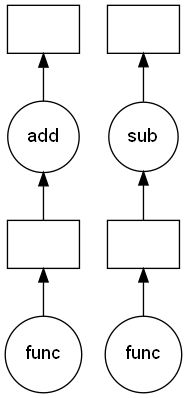

In [11]:
dask.visualize(delayed1, delayed2)

### visualize the task graph

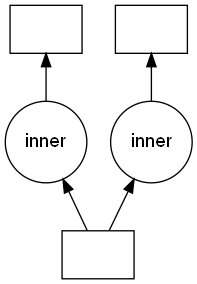

In [19]:
month_1_costs = np.random.randint(50, 300, size=20).tolist()
month_2_costs = np.random.randint(70, 250, size=20).tolist()

# Add the two delayed month costs
total_costs = delayed(month_1_costs + month_2_costs)

# Calculate the fraction of total cost from month 1
month_1_fraction = month_1_costs / total_costs

# Calculate the fraction of total cost from month 2
month_2_fraction = month_2_costs / total_costs

# Plot the joint task graph used to calculate the fractions
dask.visualize(month_1_fraction, month_2_fraction)

### Read files and delay

In [35]:
files = os.listdir('songs_data')
max_length = []

calc_max = lambda x: x['duration_ms'].max()

for file in files:
    file_df = delayed(pd.read_csv)(f'songs_data/{file}')
    max_length.append(calc_max(file_df))

absolute_maximum = delayed(max)(max_length)
print(absolute_maximum.compute())

5403500


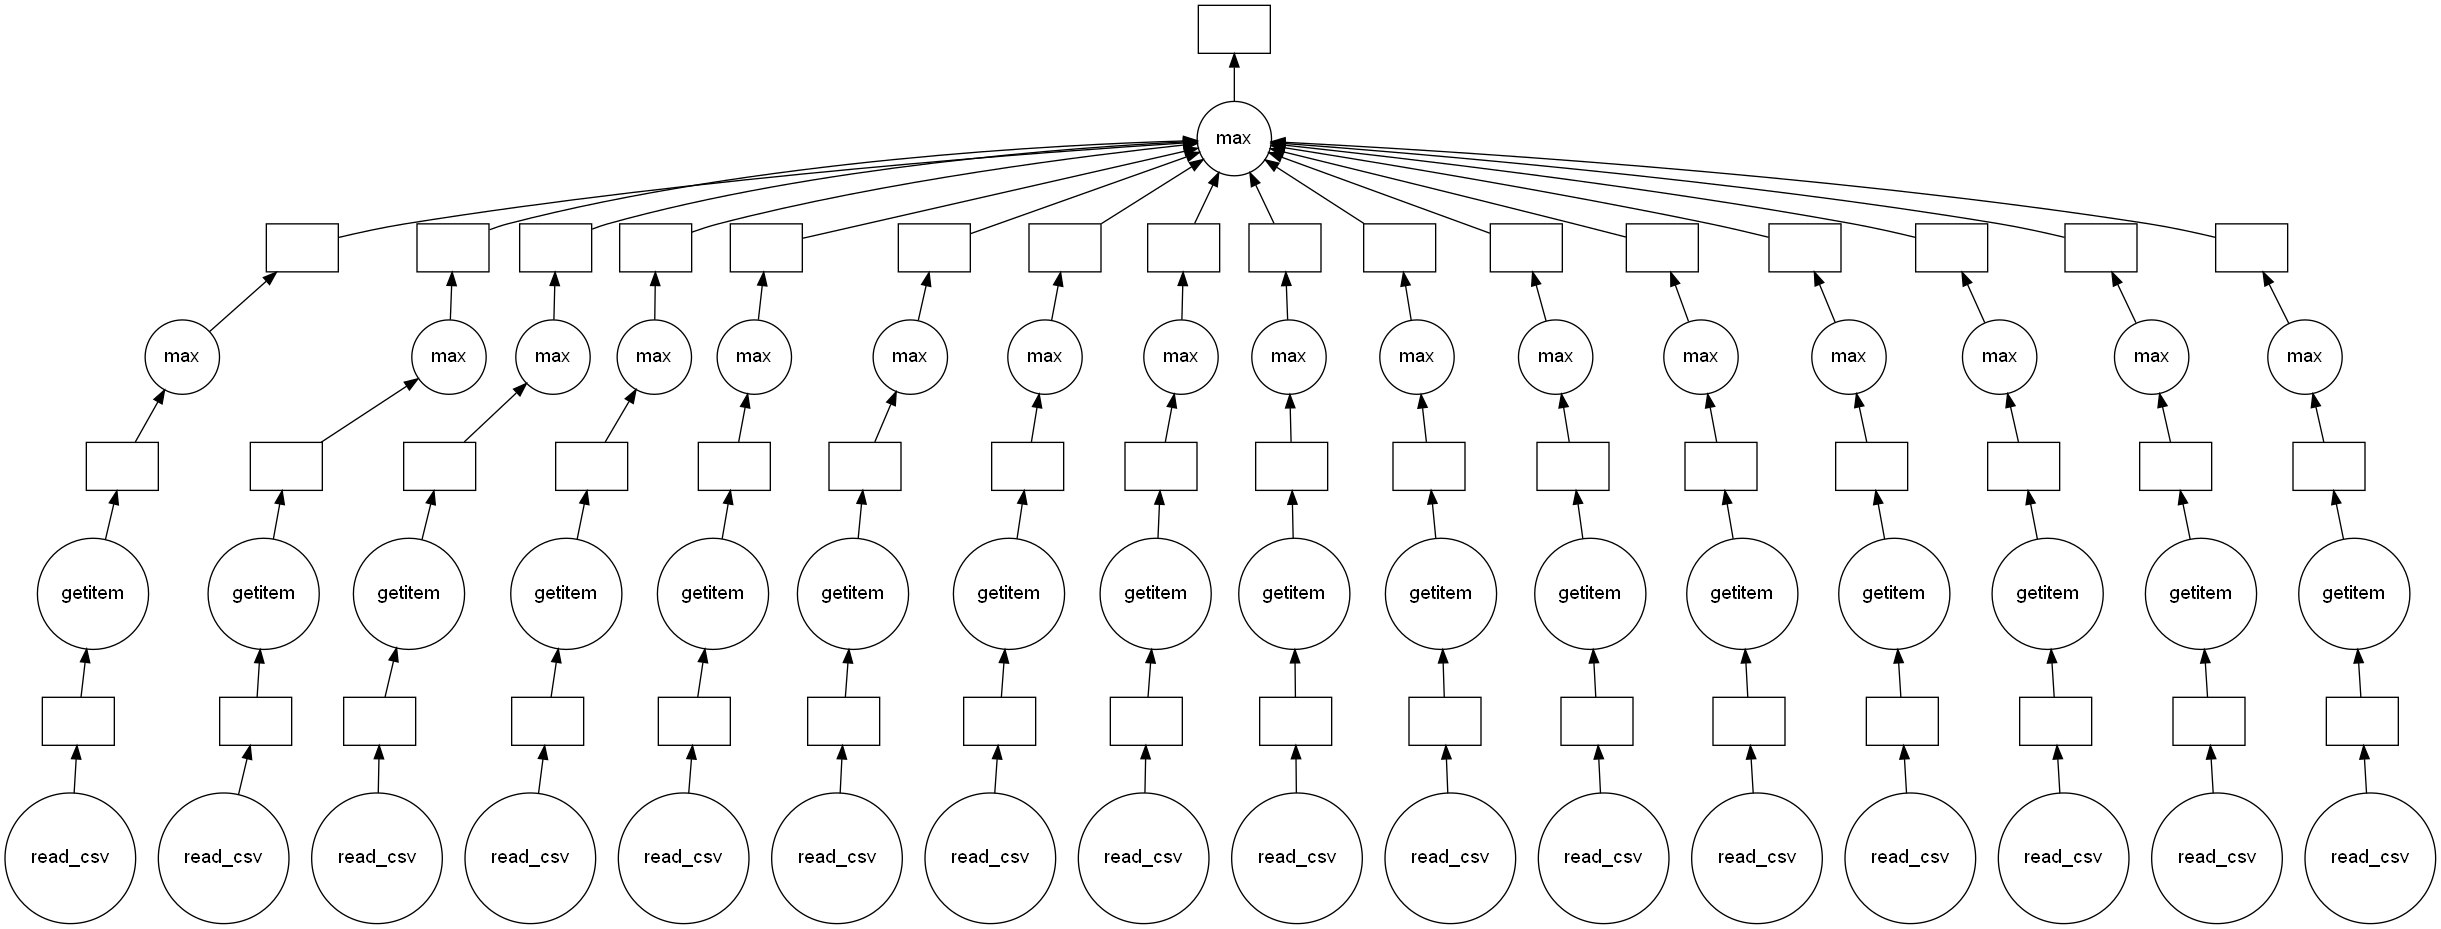

In [36]:
absolute_maximum.visualize()

In [38]:
top_songs = []

def top_10_most_popular(df):
  return df.nlargest(n=10, columns='popularity')


for file in files:
    df = delayed(pd.read_csv)(f'songs_data/{file}')
    # Find the top 10 most popular songs in this file
    df_top_10 = top_10_most_popular(df)
    top_songs.append(df_top_10)

# Compute the list of top 10s
top_songs_list = dask.compute(top_songs)[0]

# Concatenate them and find the best of the best
top_songs_df = pd.concat(top_songs_list)
df_all_time_top_10 = top_10_most_popular(top_songs_df)
print(df_all_time_top_10)

                           id                    name  popularity  \
2257   5QO79kh1waicV47BqGRL3g         Save Your Tears          97   
11698  6tDDoYIxWvMLTdKpjFkc1B               telepatía          97   
2280   0VjIjW4GlUZAMYd2vXMi3b         Blinding Lights          96   
7835   6f3Slt0GbA2bPZlz0aIFXN            The Business          95   
9090   60ynsPSSKe6O3sfwRnIBRf                 Streets          94   
2489   3FAJ6O0NOHQV8Mc5Ri6ENp  Heartbreak Anniversary          94   
10238  27OeeYzk6klgBh83TSvGMA             WITHOUT YOU          94   
11850  1xK1Gg9SxG8fy2Ya373oqb                 Bandido          94   
11238  2XIc1pqjXV3Cr2BQUGNBck      LA NOCHE DE ANOCHE          93   
13368  3YJJjQPAbDT7mGpX3WtQ9A               Good Days          93   

       duration_ms  explicit                   artists release_date  \
2257        215627         1            ['The Weeknd']   2020-03-20   
11698       160191         0            ['Kali Uchis']   2020-12-04   
2280        200040         

### Dask arrays

In [39]:
import dask.array as da

x = da.ones((4000, 6000), chunks=(1000, 2000))

### Dask DFs

In [ ]:
import dask.dataframe as dd

x = dd.read_csv('songs_data/*.csv', blocksize='10MB')
x

### Parquet

In [42]:
# Read the spotify_parquet folder
df = dd.read_parquet('song_parquet')

# Find the 10 most popular songs
top_10_songs = df.nlargest(10, 'popularity')

# Convert the delayed result to a pandas DataFrame
top_10_songs_df = top_10_songs.compute()

print(top_10_songs_df)

                           id                    name  popularity  \
2257   5QO79kh1waicV47BqGRL3g         Save Your Tears          97   
11698  6tDDoYIxWvMLTdKpjFkc1B               telepatía          97   
2280   0VjIjW4GlUZAMYd2vXMi3b         Blinding Lights          96   
7835   6f3Slt0GbA2bPZlz0aIFXN            The Business          95   
9090   60ynsPSSKe6O3sfwRnIBRf                 Streets          94   
2489   3FAJ6O0NOHQV8Mc5Ri6ENp  Heartbreak Anniversary          94   
10238  27OeeYzk6klgBh83TSvGMA             WITHOUT YOU          94   
11850  1xK1Gg9SxG8fy2Ya373oqb                 Bandido          94   
11238  2XIc1pqjXV3Cr2BQUGNBck      LA NOCHE DE ANOCHE          93   
13368  3YJJjQPAbDT7mGpX3WtQ9A               Good Days          93   

       duration_ms  explicit                   artists release_date  \
2257        215627         1            ['The Weeknd']   2020-03-20   
11698       160191         0            ['Kali Uchis']   2020-12-04   
2280        200040         

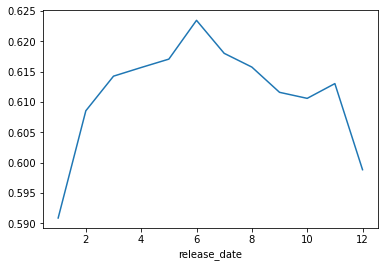

In [45]:
# Extract the months from the release_date column using its datetime accessor
months = df['release_date'].dt.month

# Group the danceabilities by month
monthly_groupby = df['danceability'].groupby(months)

# Find the mean danceability by month
monthly_danceability = monthly_groupby.mean()

# Compute the result
monthly_danceability_result = monthly_danceability.compute()

monthly_danceability_result.plot()
plt.show()

### HDF5 format

In [48]:
import h5py

file = h5py.File('data/era_eu.hdf5')
file.keys()

<KeysViewHDF5 ['latitude', 'longitude', 'month', 'precip', 'temp', 'year']>

In [50]:
dataset_a = file['/latitude']
dataset_a

<HDF5 dataset "latitude": shape (30,), type "<f8">

In [54]:
da.from_array(dataset_a, chunks=(10, ))

dask.array<array, shape=(30,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>

<KeysViewHDF5 ['latitude', 'longitude', 'month', 'precip', 'temp', 'year']>


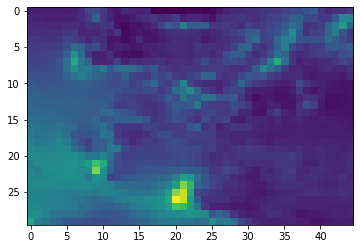

In [60]:
# Open the HDF5 dataset using h5py
hdf5_file = h5py.File('data/era_eu.hdf5')
print(hdf5_file.keys())
# Load the file into a Dask array with a reasonable chunk size
precip = da.from_array(hdf5_file['/precip'], chunks=(12, 15, 15))

# Select only the months of January
january_rainfalls = precip[0::12]

# Calculate the mean rainfall in January for each location
january_mean_rainfall = january_rainfalls.mean(axis=0)

plt.imshow(january_mean_rainfall.compute())
plt.show()

### Zarr

In [57]:
a = da.from_zarr('era_eu.zarr', component='lat')

In [58]:
a

dask.array<from-zarr, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>

In [63]:
# Load the temperature data from the Zarr dataset
temps = da.from_zarr('era_eu.zarr', component='temp')

# Print the Dask array of temperatures to see the chunk sizes
print(temps)

# Find the minimum of the mean monthly temperatures
all_time_low = temps.min()

# Compute the answer
all_time_low_value = all_time_low.compute()

print(all_time_low_value, "°C")

dask.array<from-zarr, shape=(504, 30, 45), dtype=float32, chunksize=(12, 15, 15), chunktype=numpy.ndarray>
-23.37648 °C


### Xarray

In [2]:
import xarray

ds = xarray.open_zarr('era_eu.zarr')
ds

<xarray.Dataset>
Dimensions:  (lat: 30, lon: 45, time: 504)
Coordinates:
  * lat      (lat) float64 35.5 36.5 37.5 38.5 39.5 ... 60.5 61.5 62.5 63.5 64.5
  * lon      (lon) float64 -14.5 -13.5 -12.5 -11.5 -10.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1979-05-31 1979-06-30 ... 2021-04-30
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(12, 15, 15), meta=np.ndarray>
    temp     (time, lat, lon) float32 dask.array<chunksize=(12, 15, 15), meta=np.ndarray>

In [8]:
ds.sel(time='1979-05-31')

<xarray.Dataset>
Dimensions:  (lat: 30, lon: 45)
Coordinates:
  * lat      (lat) float64 35.5 36.5 37.5 38.5 39.5 ... 60.5 61.5 62.5 63.5 64.5
  * lon      (lon) float64 -14.5 -13.5 -12.5 -11.5 -10.5 ... 26.5 27.5 28.5 29.5
    time     datetime64[ns] 1979-05-31
Data variables:
    precip   (lat, lon) float32 dask.array<chunksize=(15, 15), meta=np.ndarray>
    temp     (lat, lon) float32 dask.array<chunksize=(15, 15), meta=np.ndarray>

In [9]:
ds['lon']

<xarray.DataArray 'lon' (lon: 45)>
array([-14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,
        -4.5,  -3.5,  -2.5,  -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,
         5.5,   6.5,   7.5,   8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,
        15.5,  16.5,  17.5,  18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,
        25.5,  26.5,  27.5,  28.5,  29.5])
Coordinates:
  * lon      (lon) float64 -14.5 -13.5 -12.5 -11.5 -10.5 ... 26.5 27.5 28.5 29.5
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

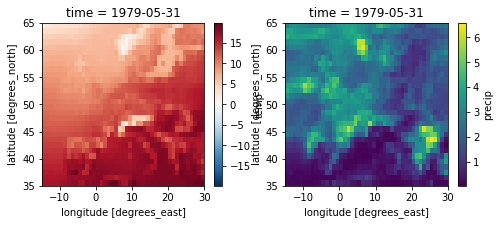

In [12]:
# Select the zeroth time in the DataSet
ds_sel = ds.isel(time=0)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 3))

# Plot the zeroth temperature field on ax1
ds_sel['temp'].plot(ax=ax1)

# Plot the zeroth precipitation field on ax2
ds_sel['precip'].plot(ax=ax2)
plt.show()

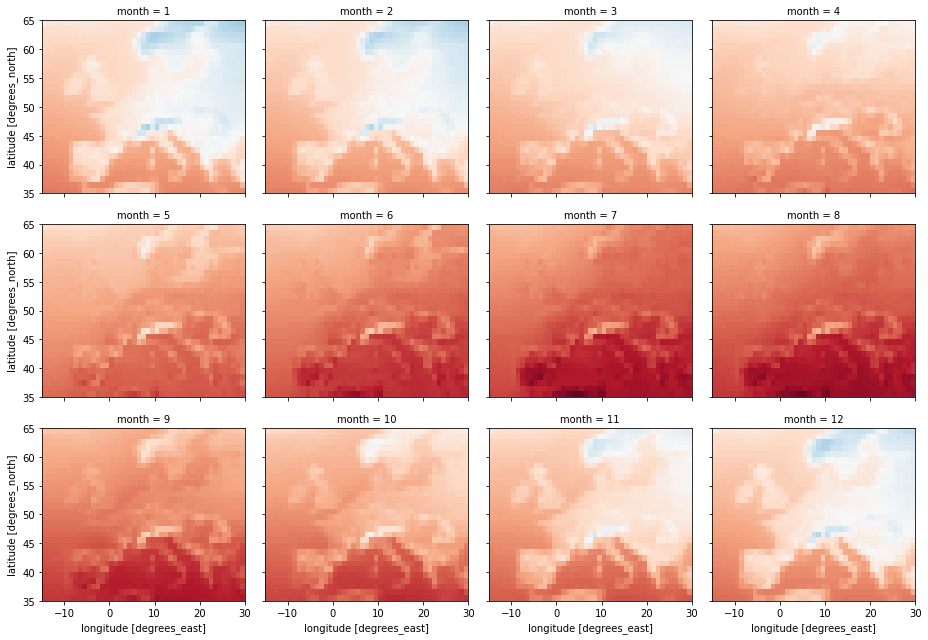

In [13]:
# Extract the months from the time coordinates
months = ds['time'].dt.month

# Select the temp DataArray and group by months
monthly_groupby = ds['temp'].groupby(months)

# Find the mean temp by month
monthly_mean_temps = monthly_groupby.mean()

# Compute the result
monthly_mean_temps_computed = monthly_mean_temps.compute()

monthly_mean_temps_computed.plot(col='month', col_wrap=4, add_colorbar=False)
plt.show()

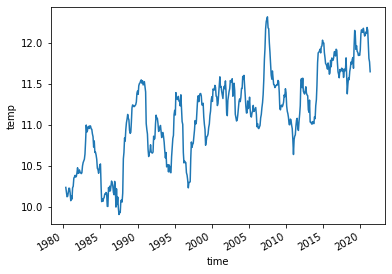

In [17]:
# Open the ERA5 dataset
ds = xarray.open_zarr('era_eu.zarr')

# Select the temperature dataset and take the latitude and longitude mean
temp_timeseries = ds['temp'].mean(dim=('lat', 'lon'))

# Calculate the 12 month rolling mean
temp_rolling_mean = temp_timeseries.rolling(time=12).mean()

# Plot the result
temp_rolling_mean.plot()
plt.show()